# **Clustering (with K-Means) for the Flood Risk Zone**

##### <span style="color:green;">Setelah menganalisis curah hujan, deforestasi, kemiringan lahan, kepadatan penduduk, dan juga dampak banjir pada wilayah Aceh, kali ini saya mengimplementasikan clustering untuk mengetahui daerah mana yang paling berisiko. Semua data hasil analisis dari sebelumnya sudah di-*aggregate* menjadi satu dataset sehingga bisa diimplementasikan model K-Means Clustering untuk analisis zona risiko. Namun, pertama kita akan melakukan EDA dari datasetnya, hanya untuk mengetahui apakah struktur dari datanya sudah benar atau tidak, lalu dilanjutkan dengan implementasi clustering untuk mengetahui tiap daerah termasuk zona risiko yang mana.</span>

## Import Library

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Exploratory Data Analysis

## Load Dataset

In [3]:
df = pd.read_csv("Aggregated_Data.csv")
df.head()


,kabupaten,kab_clean,kepadatan_penduduk_km2,total_deforestasi,kemiringan_rata2_persen,total_korban
0,Simeulue,simeulue,47,2654,22.500000,0.0
1,Aceh Singkil,aceh singkil,61,7668,3.000000,0.0
2,Aceh Selatan,aceh selatan,62,10802,22.500000,0.0
3,Aceh Tenggara,aceh tenggara,55,3951,21.333333,13.0
4,Aceh Timur,aceh timur,70,15686,8.000000,53.0


## Graph Set Up

In [4]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 12))

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

## Heatmap Correlation

Text(0.5, 1.0, 'Correlation: Apakah Deforestasi Menambah Korban?')

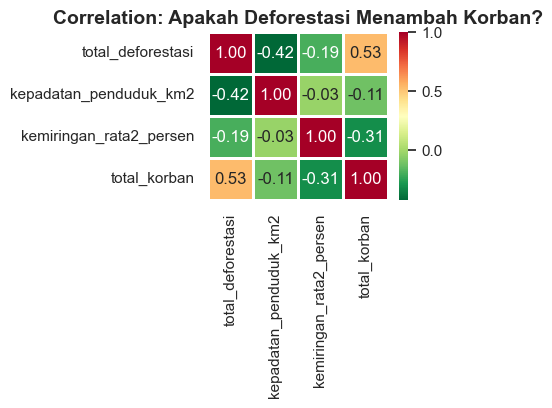

In [7]:
plt.subplot(2, 2, 1)
cols_to_check = ['total_deforestasi', 'kepadatan_penduduk_km2', 'kemiringan_rata2_persen', 'total_korban']
corr_matrix = df[cols_to_check].corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn_r', fmt=".2f", linewidths=1)
plt.title('Correlation: Apakah Deforestasi Menambah Korban?', fontsize=14, fontweight='bold')

## Scatter Plot

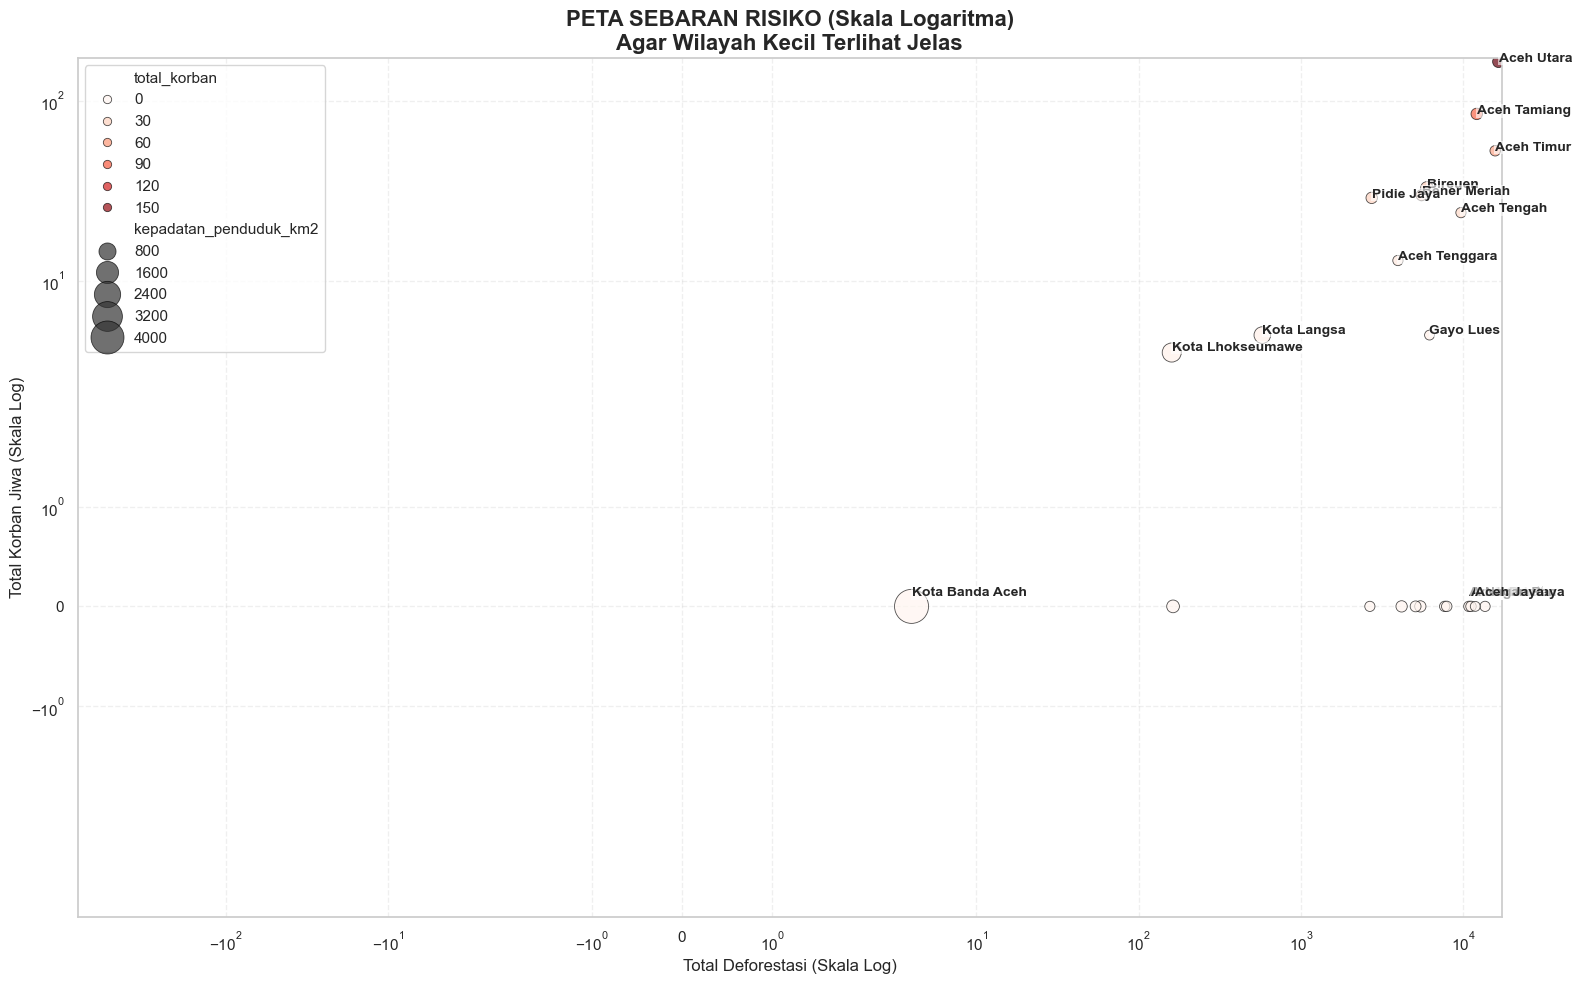

In [14]:
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=df,
    x='total_deforestasi',
    y='total_korban',
    size='kepadatan_penduduk_km2',
    sizes=(50, 600),
    hue='total_korban',
    palette='Reds',
    alpha=0.7,
    edgecolor='black'
)

plt.xscale('symlog') 
plt.yscale('symlog') 

texts = []
for i in range(df.shape[0]):
    x_val = df.total_deforestasi.iloc[i]
    y_val = df.total_korban.iloc[i]
    nama = df.kabupaten.iloc[i]

    if y_val > 0 or x_val > 8000 or df.kepadatan_penduduk_km2.iloc[i] > 1000:
        plt.text(
            x_val, 
            y_val + 0.1, 
            nama, 
            fontsize=10, 
            weight='bold',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5)
        )

plt.title('PETA SEBARAN RISIKO (Skala Logaritma)\nAgar Wilayah Kecil Terlihat Jelas', fontsize=16, fontweight='bold')
plt.xlabel('Total Deforestasi (Skala Log)', fontsize=12)
plt.ylabel('Total Korban Jiwa (Skala Log)', fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout()
plt.show()

## Outlier Check

Text(0.5, 0, 'Jiwa per Km2')

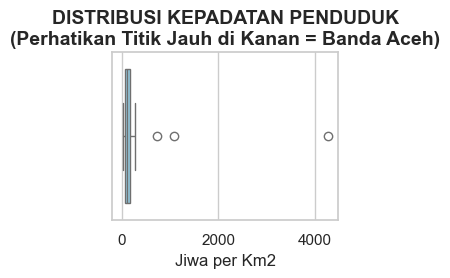

In [15]:
plt.subplot(2, 2, 3)
sns.boxplot(x=df['kepadatan_penduduk_km2'], color='skyblue')
plt.title('DISTRIBUSI KEPADATAN PENDUDUK\n(Perhatikan Titik Jauh di Kanan = Banda Aceh)', fontsize=14, fontweight='bold')
plt.xlabel('Jiwa per Km2')

## Deforestasi

/var/folders/56/8d3syb8j4mg02r592bf9hjc00000gn/T/ipykernel_59458/398692975.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_deforest, x='total_deforestasi', y='kabupaten', palette='RdPu_r')


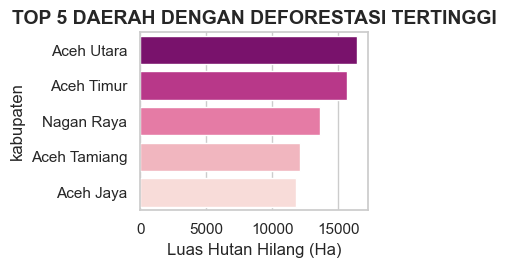

In [19]:
plt.subplot(2, 2, 4)
top_deforest = df.sort_values('total_deforestasi', ascending=False).head(5)
sns.barplot(data=top_deforest, x='total_deforestasi', y='kabupaten', palette='RdPu_r')
plt.title('TOP 5 DAERAH DENGAN DEFORESTASI TERTINGGI', fontsize=14, fontweight='bold')
plt.xlabel('Luas Hutan Hilang (Ha)')

plt.tight_layout()
plt.show()

# Clustering (K-Means)

## Pemilihan Fitur

In [21]:
features = ['total_deforestasi', 'kepadatan_penduduk_km2', 'kemiringan_rata2_persen', 'total_korban']
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

## Load K-Means

In [22]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster_id'] = kmeans.fit_predict(df_scaled)

## Define Cluster
#### Cluster dengan rata-rata korban & deforestasi tertinggi adalah "High Risk"

In [23]:
cluster_mean = df.groupby('cluster_id')[['total_korban', 'total_deforestasi']].mean()
cluster_mean['score'] = cluster_mean['total_korban'] + (cluster_mean['total_deforestasi'] / 100) 
sorted_clusters = cluster_mean.sort_values('score', ascending=False).index

## Cluster Mapping

In [24]:
risk_mapping = {
    sorted_clusters[0]: 'Risiko Tinggi (Zona Merah)',
    sorted_clusters[1]: 'Risiko Sedang (Zona Kuning)',
    sorted_clusters[2]: 'Risiko Rendah (Zona Hijau)'
}
df['Status Risiko'] = df['cluster_id'].map(risk_mapping)

## Visualization

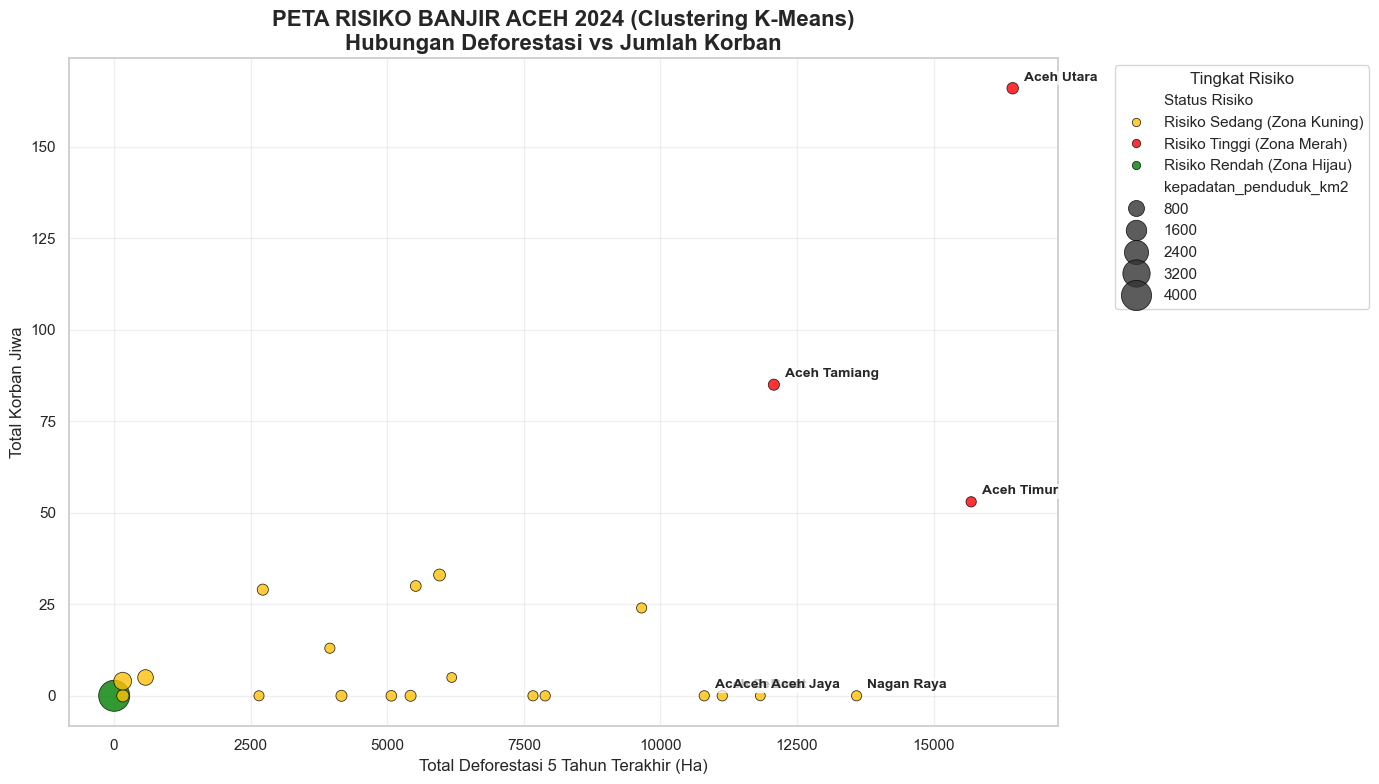

HASIL PENGELOMPOKAN WILAYAH (TOP 10)


,kabupaten,total_korban,total_deforestasi,Status Risiko
10,Aceh Utara,166.0,16446,Risiko Tinggi (Zona Merah)
13,Aceh Tamiang,85.0,12076,Risiko Tinggi (Zona Merah)
4,Aceh Timur,53.0,15686,Risiko Tinggi (Zona Merah)
9,Bireuen,33.0,5958,Risiko Sedang (Zona Kuning)
16,Bener Meriah,30.0,5523,Risiko Sedang (Zona Kuning)
17,Pidie Jaya,29.0,2724,Risiko Sedang (Zona Kuning)
5,Aceh Tengah,24.0,9656,Risiko Sedang (Zona Kuning)
3,Aceh Tenggara,13.0,3951,Risiko Sedang (Zona Kuning)
20,Kota Langsa,5.0,578,Risiko Sedang (Zona Kuning)
12,Gayo Lues,5.0,6181,Risiko Sedang (Zona Kuning)


In [26]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

scatter = sns.scatterplot(
    data=df,
    x='total_deforestasi',
    y='total_korban',
    hue='Status Risiko',
    palette={'Risiko Tinggi (Zona Merah)': 'red', 'Risiko Sedang (Zona Kuning)': '#FFC107', 'Risiko Rendah (Zona Hijau)': 'green'},
    size='kepadatan_penduduk_km2',
    sizes=(50, 500), 
    alpha=0.8,
    edgecolor='black'
)

for i in range(df.shape[0]):
    status = df['Status Risiko'].iloc[i] 
    deforestasi = df['total_deforestasi'].iloc[i]
    korban = df['total_korban'].iloc[i]
    nama_kab = df['kabupaten'].iloc[i]

    if status == 'Risiko Tinggi (Zona Merah)' or deforestasi > 10000:
        plt.text(
            x=deforestasi + 200,    
            y=korban + 2,        
            s=nama_kab, 
            fontsize=10, 
            weight='bold',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
        )

plt.title('PETA RISIKO BANJIR ACEH 2024 (Clustering K-Means)\nHubungan Deforestasi vs Jumlah Korban', fontsize=16, fontweight='bold')
plt.xlabel('Total Deforestasi 5 Tahun Terakhir (Ha)', fontsize=12)
plt.ylabel('Total Korban Jiwa', fontsize=12)
plt.legend(title='Tingkat Risiko', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("HASIL PENGELOMPOKAN WILAYAH (TOP 10)")
display(df[['kabupaten', 'total_korban', 'total_deforestasi', 'Status Risiko']].sort_values('total_korban', ascending=False).head(10))

df.to_csv('Hasil_Analisis_Risiko_Banjir_Aceh.csv', index=False)